# Calculo de Normalized Difference Water Index (NDWI)

Este indice permite obtener los cambios relacionado al contenido de agua de los cuerpos. Para mas información ver [McFeeters (1996)](https://www.tandfonline.com/doi/abs/10.1080/01431169608948714). La ecuación que representa al indice es la siguiente, aunque dependiendo de la mision las bandas correspondientes a green y Nir pueden variar de numeración. Ejemplo Sentinel 2 B3 (Banda Verde) y B8 (Banda NIR) o Landsat 8 B3 (Banda verde) y B5 (Banda NIR).

$$NDWI=\frac{B_{green}-B_{NIR}}{B_{green}+B_{NIR}}$$ 

**Objetivo:**
En este notebook seleccionaremos una area de interes y calcularemos como varia la superficie expuesta de agua de dicha zona.

## Trabajamos sobre una zona de interes

In [1]:
# Importamos las librerías necesarias
import os
import ee
import geemap

ModuleNotFoundError: No module named 'ee'

In [2]:
Map = geemap.Map()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

Se define la zona de interes en el mapa previo.

In [3]:
#zona de interes
feature = Map.draw_last_feature
roi = feature.geometry()

In [4]:
#parametros de filtrado de las imágenes satelitales
start_date = '2021-01-01'#fecha de inicio 
end_date = '2022-05-06'#fecha final
cloud_threshold = 50#porcentaje de nubes
ndwi_threshold = 0

In [5]:
#aplicamos losfiltros indicados previamente
images = (
    ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')
    .filterBounds(roi)
    .filterDate(start_date, end_date)
    .filterMetadata('CLOUD_COVER', 'less_than', cloud_threshold)
)

In [6]:
#imprimimos cuantas imagenes tenemos
print(images.size().getInfo())

17


In [7]:
#imprimimos información de las imagenes
print(images.aggregate_array('system:id').getInfo())

['LANDSAT/LC08/C01/T1_SR/LC08_227082_20210102', 'LANDSAT/LC08/C01/T1_SR/LC08_227082_20210118', 'LANDSAT/LC08/C01/T1_SR/LC08_227082_20210307', 'LANDSAT/LC08/C01/T1_SR/LC08_227082_20210323', 'LANDSAT/LC08/C01/T1_SR/LC08_227082_20210408', 'LANDSAT/LC08/C01/T1_SR/LC08_227082_20210510', 'LANDSAT/LC08/C01/T1_SR/LC08_227082_20210526', 'LANDSAT/LC08/C01/T1_SR/LC08_227082_20210611', 'LANDSAT/LC08/C01/T1_SR/LC08_227082_20210627', 'LANDSAT/LC08/C01/T1_SR/LC08_227082_20210729', 'LANDSAT/LC08/C01/T1_SR/LC08_227082_20210814', 'LANDSAT/LC08/C01/T1_SR/LC08_227082_20210830', 'LANDSAT/LC08/C01/T1_SR/LC08_227082_20210915', 'LANDSAT/LC08/C01/T1_SR/LC08_227082_20211001', 'LANDSAT/LC08/C01/T1_SR/LC08_227082_20211017', 'LANDSAT/LC08/C01/T1_SR/LC08_227082_20211118', 'LANDSAT/LC08/C01/T1_SR/LC08_227082_20211220']


In [8]:
#imprimimos las fechas de las imagenes que obtuvimos
dates = images.aggregate_array('system:time_start').map(
    lambda d: ee.Date(d).format('YYYY-MM-dd')
)
print(dates.getInfo())

['2021-01-02', '2021-01-18', '2021-03-07', '2021-03-23', '2021-04-08', '2021-05-10', '2021-05-26', '2021-06-11', '2021-06-27', '2021-07-29', '2021-08-14', '2021-08-30', '2021-09-15', '2021-10-01', '2021-10-17', '2021-11-18', '2021-12-20']


In [9]:
#creamos una función 
def extract_water(img):
    '''La entrada es la secuencia de imágenes que hemos extraído previamente.
    La salida las imagenes seleccionadas con el NDWI limite'''
    ndwi_image = img.normalizedDifference(['B3', 'B5'])
    water_image = ndwi_image.gt(ndwi_threshold)
    return water_image

In [10]:
#aplicamos la función previa y extraemos el NDWI
ndwi_images = images.map(extract_water)

In [11]:
#imprimimos la ocurrence de agua
occurrence = ndwi_images.sum().selfMask()
Map.addLayer(occurrence.randomVisualizer(), {}, 'Water Occurrence')

In [12]:
#pasamos la info de raster a vector
def ras_to_vec(img):
    vec = img.selfMask().reduceToVectors(scale=30, maxPixels=70000000)
    vec = vec.filterBounds(roi)
    return vec.set({'area': vec.geometry().area(1).divide(1e6).round()})

In [13]:
#convertimos de raster a vector
ndwi_vectors = ndwi_images.map(ras_to_vec)

In [14]:
#calculamos el area
areas = ndwi_vectors.aggregate_array('area')
print(areas.getInfo())

[609, 629, 740, 642, 322, 372, 649, 0, 463, 539, 18, 437, 614, 539, 589, 611, 4]


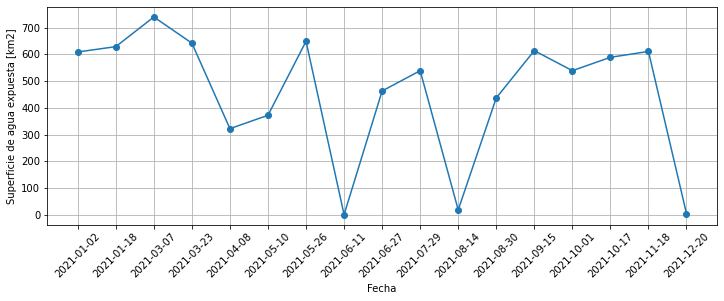

In [15]:
#ploteamos la variación de la superficie expuesta
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 4))

x = dates.getInfo()#seteamos el eje x
y = areas.getInfo()#seteamos el eje y

plt.plot(x, y, marker='o')
plt.xlabel('Fecha')
plt.ylabel('Superficie de agua expuesta [km2]')
plt.xticks(rotation=45) 
plt.grid()
plt.show()
#plt.savefig('figure_NDWI.tif', dpi=100)